In [4]:
from datasets import DatasetDict, Dataset
from datasets import load_dataset
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
import ssl
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
from sentencepiece import SentencePieceProcessor
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
import tensorflow as tf
import os

/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part 0: Dataset Preparation

In [5]:
dataset: DatasetDict = load_dataset("cornell-movie-review-data/rotten_tomatoes")
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
# Tokenize Words

# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Set the NLTK data path to the current directory's nltk_data folder
nltk_data_path = os.path.join(os.getcwd(), "nltk_data")
nltk.data.path.append(nltk_data_path)

# Download necessary tokenizer data to the specified folder
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path)

print(f"NLTK data saved to: {nltk_data_path}")

NLTK data saved to: /Users/kristiyancholakov/Programming/PyCharmProjects/SC4002/group_assignment/nltk_data


[nltk_data] Downloading package punkt to /Users/kristiyancholakov/Prog
[nltk_data]     ramming/PyCharmProjects/SC4002/group_assignment/nltk_d
[nltk_data]     ata...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kristiyancholakov/Pr
[nltk_data]     ogramming/PyCharmProjects/SC4002/group_assignment/nltk
[nltk_data]     _data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/kristiyancholakov/
[nltk_data]     Programming/PyCharmProjects/SC4002/group_assignment/nl
[nltk_data]     tk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
def tokenize(row):
    text: str = row['text']
    # Tokenize text into words using NLTK
    row["tokens"] =  word_tokenize(text.lower())

    return row

train = train.map(tokenize)
val = val.map(tokenize)
test = test.map(tokenize)

In [8]:
# Build Vocabulary
def build_vocab(data: Dataset, column: str):
    vocab = Counter()
    for row in data:
        vocab.update(row[column])
    return vocab

vanilla_vocab = build_vocab(train, "tokens")

In [9]:
vanilla_vocab

Counter({'.': 11197,
         'the': 8034,
         ',': 8001,
         'a': 5879,
         'and': 4918,
         'of': 4815,
         'to': 3416,
         "'s": 2872,
         'is': 2848,
         'it': 2733,
         'that': 2129,
         'in': 2112,
         'as': 1409,
         'but': 1326,
         'with': 1274,
         'film': 1248,
         'this': 1187,
         'for': 1161,
         'movie': 1078,
         'an': 1067,
         'its': 1060,
         'you': 940,
         'be': 771,
         "n't": 741,
         'on': 719,
         'not': 661,
         'by': 653,
         'are': 592,
         'about': 581,
         'more': 575,
         'one': 574,
         'like': 572,
         'has': 561,
         'at': 557,
         'from': 542,
         '--': 536,
         'than': 529,
         'his': 519,
         'have': 515,
         '``': 507,
         'all': 504,
         'i': 466,
         'so': 446,
         "'": 438,
         'or': 422,
         'if': 419,
         'story': 384,
   

### Question 1a:
What is the size of the vocabulary formed from your training data?


In [10]:
# Vocabulary Size
vocab_size = len(vanilla_vocab)
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 18029


In [11]:
import gensim
from gensim.models import KeyedVectors
import os
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np  # Import NumPy for array handling

# Define base folder for GloVe files
glove_folder = "glove"
glove_path = os.path.join(glove_folder, "glove.6B.300d.txt")
# Dynamically create the word2vec path based on the glove path
word2vec_glove_path = glove_path.replace(".txt", ".word2vec.txt")

# Check if the conversion has already been done successfully
def convert_glove_to_word2vec(glove_path, word2vec_path):
    if not os.path.exists(word2vec_path):
        print("Converting GloVe to Word2Vec format...")
        glove2word2vec(glove_path, word2vec_path)
        print("Conversion complete.")
    else:
        print("Converted GloVe file already exists.")

# Perform the conversion if necessary
convert_glove_to_word2vec(glove_path, word2vec_glove_path)

# Load the embeddings and apply lowercase handling
try:
    print("Loading Word2Vec formatted embeddings...")
    # Load the original embeddings without specifying no_header=True
    embed_model = KeyedVectors.load_word2vec_format(word2vec_glove_path, binary=False)

    # Create a dictionary with lowercase keys and corresponding vectors
    lowercase_embeddings = {word.lower(): embed_model[word] for word in embed_model.key_to_index}

    # Initialize a new KeyedVectors instance from the dictionary
    embed_model_lower = KeyedVectors(vector_size=embed_model.vector_size)

    # Convert the list of vectors to a 2D NumPy array
    keys = list(lowercase_embeddings.keys())
    vectors = np.array(list(lowercase_embeddings.values()))

    # Add the vectors to the new KeyedVectors instance
    embed_model_lower.add_vectors(keys, vectors)

    # Replace the original model with the lowercased model
    embed_model = embed_model_lower
    print("Embeddings loaded and converted to lowercase successfully.")

except EOFError:
    print("Error: Unexpected end of input. The file may be incomplete or corrupted.")
except Exception as e:
    print(f"An error occurred: {e}")


Converted GloVe file already exists.
Loading Word2Vec formatted embeddings...
Embeddings loaded and converted to lowercase successfully.


In [12]:
word2vec_vocab_lst = embed_model.key_to_index.keys()

### Question 1b:
We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?

In [13]:
# Find OoV Words
oov_words = [word for word in vanilla_vocab if word not in word2vec_vocab_lst]
print("Number of OoV words:", len(oov_words))

Number of OoV words: 1865


In [14]:
print(oov_words)

['jean-claud', 'co-writer/director', 'too-tepid', 'wisegirls', "'who", 'enrapturing', 'fulford-wierzbicki', 'laissez-passer', "'compleja", 'intelectualmente', 'retadora', 'orquídeas', 'originalidad', 'parka-wrapped', 'singer/composer', '\x97', "'performance", 'comedy/thriller', "early-'80s", 'lovers-on-the-run', 'again-courage', 'suspenser', 'memory-as-identity', 'obviation', 'b-scene', 'digital-video', "'truth", 'gorefests', 'waydowntown', 'conan-esque', '\x96', 'sock-you-in-the-eye', 'non-reactionary', 'near-disaster', 'makmalbaf', "'urban", 'exhilarate', 'ever-escalating', 'nuttgens', 'heavy-handedness', 'lump-in-the-throat', 'bigger-than-life', 'ming-liang', 'spy-movie', 'slice-of-depression', 'political-action', 'petin', 'provocatuers', 'jirí', 'hubac', 'third-act', 'shapelessly', 'anti-date', 'port-of-call', 'talking-head', 'meet-cute', 'connect-the-dots', 'spy-on-the-run', 'real-live', '179-minute', "'bartleby", 'saucer-eyed', 'downy-cheeked', 'award-worthy', 'addessi', 'heartbe

In [15]:
def process_tokens(tokens, oov_list, word2vec_model):
    processed_tokens = []

    for token in tokens:
        if token in oov_list:
            # Case 1: Token contains "'" and is in OOV list
            if "'" in token:
                # Remove apostrophe from the token
                processed_tokens.append(token.replace("'", ''))
            # Case 2: Token contains '-' and is in OOV list
            elif '-' in token:
                # Split the token on '-'
                split_tokens = token.split('-')

                # Check if all split parts exist in Word2Vec
                if all(sub_token in word2vec_model for sub_token in split_tokens):
                    # If all parts are in the Word2Vec vocabulary, split it
                    processed_tokens.extend(split_tokens)
                else:
                    # Else, merge it by removing '-'
                    processed_tokens.append(token.replace('-', ''))
            else:
                # If it's an OOV token but doesn't match other cases, keep it as-is
                processed_tokens.append(token)
        else:
            # If the token is not in OOV, keep it as-is
            processed_tokens.append(token)

    return processed_tokens

train = train.map(lambda row: {"processed_tokens": process_tokens(row["tokens"], oov_words, embed_model)})
val = val.map(lambda row: {"processed_tokens": process_tokens(row["tokens"], oov_words, embed_model)})
test = test.map(lambda row: {"processed_tokens": process_tokens(row["tokens"], oov_words, embed_model)})

In [16]:
# Build Vocab
processed_vocab = build_vocab(train, "processed_tokens")

# Find OoV Words
processed_oov_words = [word for word in processed_vocab if word not in word2vec_vocab_lst]
print("Number of OoV words:", len(processed_oov_words))

Number of OoV words: 668


In [17]:
# Lemmatize the OOV words
def lemmatize_oov_words(tokens, oovs):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token in tokens:
        if token in oovs:
            # Apply lemmatization to OOV word
            lemmatized_tokens.append(lemmatizer.lemmatize(token))
        else:
            # Keep in-vocab words unchanged
            lemmatized_tokens.append(token)
    return lemmatized_tokens

train = train.map(lambda row: {"lemmatized_tokens": lemmatize_oov_words(row["processed_tokens"], oov_words)})
val = val.map(lambda row: {"lemmatized_tokens": lemmatize_oov_words(row["processed_tokens"], oov_words)})
test = test.map(lambda row: {"lemmatized_tokens": lemmatize_oov_words(row["processed_tokens"], oov_words)})

In [18]:
# Build Vocab
lemmatized_vocab = build_vocab(train, "lemmatized_tokens")

# Find OoV Words
lemmatized_oov_words = [word for word in lemmatized_vocab if word not in word2vec_vocab_lst]
print("Number of OoV words:", len(lemmatized_oov_words))

Number of OoV words: 659


In [19]:
print(lemmatized_oov_words)

['wisegirls', 'enrapturing', 'compleja', 'intelectualmente', 'retadora', 'orquídeas', 'originalidad', 'singer/composer', '\x97', 'comedy/thriller', 'early-80s', 'suspenser', 'obviation', 'gorefests', 'waydowntown', '\x96', 'makmalbaf', 'exhilarate', 'nuttgens', 'petin', 'provocatuers', 'jirí', 'hubac', 'shapelessly', 'addessi', 'seldahl', 'wollter', 'mullinski', 'narcotizing', 'precollegiate', 'peter/spiderman', 'sparklingly', 'gooddeed/baddeed', 'superlarge', '\x91what', 'destinees', 'margolo', 'scuzbag', 'idoosyncratic', 'flatula', 'denlopp', 'watstein', 'sappier', 'condensada', 'divertida', 'visualmente', 'entretenida', 'sorprenderá', 'exporing', 'lovejealousy', 'capturou', 'sarcástica', 'demencial', 'predecesora', 'complejos', 'cadness', 'shagster', 'hors-doeuvre', 'powaqqatsi', 'policiales', 'últimos', 'kaputschnik', 'kickass', 'travil', 'sidesplittingly', 'aborbing', 'monkeyfun', 'new/old', 'have-yourself-a-happy-little-holocaust', 'bierbichler', 'crummles', 'gutbustingly', 'stul

In [20]:
# Stem the OOV words
def stem_oov_words(tokens, oovs):
    stemmer = PorterStemmer()
    stemmed_tokens = []
    for token in tokens:
        if token in oovs:
            # Apply stemming to OOV word
            stemmed_tokens.append(stemmer.stem(token))
        else:
            # Keep in-vocab words unchanged
            stemmed_tokens.append(token)
    return stemmed_tokens

train = train.map(lambda row: {"stemmed_tokens": stem_oov_words(row["lemmatized_tokens"], oov_words)})
val = val.map(lambda row: {"stemmed_tokens": stem_oov_words(row["lemmatized_tokens"], oov_words)})
test = test.map(lambda row: {"stemmed_tokens": stem_oov_words(row["lemmatized_tokens"], oov_words)})

In [21]:
# Build Vocab
stemmed_vocab = build_vocab(train, "stemmed_tokens")

# Find OoV Words
stemmed_oov_words = [word for word in stemmed_vocab if word not in word2vec_vocab_lst]
print("Number of OoV words:", len(stemmed_oov_words))

Number of OoV words: 602


In [22]:
stemmed_oov_words

['wisegirl',
 'enraptur',
 'compleja',
 'intelectualment',
 'retadora',
 'orquídea',
 'originalidad',
 'singer/compos',
 '\x97',
 'comedy/thril',
 'early-80s',
 'suspens',
 'obviat',
 'waydowntown',
 '\x96',
 'makmalbaf',
 'exhilar',
 'nuttgen',
 'petin',
 'provocatu',
 'jirí',
 'hubac',
 'shapelessli',
 'addessi',
 'seldahl',
 'wollter',
 'mullinski',
 'narcot',
 'precollegi',
 'peter/spiderman',
 'sparklingli',
 'gooddeed/baddeed',
 'superlarg',
 '\x91what',
 'margolo',
 'scuzbag',
 'idoosyncrat',
 'flatula',
 'denlopp',
 'watstein',
 'sappier',
 'condensada',
 'divertida',
 'visualment',
 'entretenida',
 'sorprenderá',
 'expor',
 'lovejealousy',
 'captur',
 'sarcástica',
 'demenci',
 'predecesora',
 'shagster',
 'hors-doeuvre',
 'powaqqatsi',
 'kaputschnik',
 'kickass',
 'travil',
 'sidesplittingly',
 'aborb',
 'monkeyfun',
 'new/old',
 'have-yourself-a-happy-little-holocaust',
 'bierbichl',
 'crumml',
 'gutbustingly',
 'stultifyingli',
 'action/effect',
 'deutchland',
 'inhospit',


In [23]:
spp = SentencePieceProcessor()

In [24]:
spp.load(hf_hub_download(repo_id="BAAI/bge-m3", filename="sentencepiece.bpe.model"))

True

In [25]:
def tokenize_with_spp(row, token_col: str, oov):
    tokens: str = row[token_col]
    row["SP_Tokens"] = []
    # Tokenize text into words using SentencePiece
    for token in tokens:
        if token in oov:
            row["SP_Tokens"] += spp.encode_as_pieces(token)
        else:
            row["SP_Tokens"].append(token)

    return row

train = train.map(lambda row: tokenize_with_spp(row, "lemmatized_tokens", lemmatized_oov_words))
val = val.map(lambda row: tokenize_with_spp(row, "lemmatized_tokens", lemmatized_oov_words))
test = test.map(lambda row: tokenize_with_spp(row, "lemmatized_tokens", lemmatized_oov_words))

sentence_piece_vocab = dict(build_vocab(train, "SP_Tokens"))

def clean_vocab(v):
    cleaned_vocab = {}
    for token, token_id in v.items():
        # If the token length is greater than 1, remove '▁'
        if len(token) > 1:
            cleaned_token = token.replace('▁', '')
        else:
            cleaned_token = token
        # Add the cleaned token and its ID to the new vocab
        cleaned_vocab[cleaned_token] = token_id

    # Sizes of cleaned_vocab and original vocab will not match as duplicates which were previously distinct due to the '_' are now the same
    return cleaned_vocab
sentence_piece_vocab = clean_vocab(sentence_piece_vocab)

# Find OoV Words
sp_oov_words = [word for word in sentence_piece_vocab if word not in word2vec_vocab_lst]
print("Number of OoV words:", len(oov_words))

# We will hence not be using Sentence Piece since it does not help in reducing the number of OOV words

Number of OoV words: 1865


In [26]:
sp_oov_words

['▁',
 'quí',
 'idad',
 '\x97',
 'thri',
 'ller',
 'suspens',
 'obvi',
 '\x96',
 'provocat',
 'wollte',
 'inski',
 'rman',
 '\x91',
 'condensa',
 'divertida',
 'sorprend',
 'rá',
 'ástica',
 'qqa',
 'últimos',
 'tsch',
 'tting',
 'ttle',
 'stul',
 'ifying',
 'inhos',
 'næ',
 'estava',
 'existência',
 'fato',
 'ável',
 'cón',
 'gging',
 'apesar',
 'consegue',
 'tation',
 'straf',
 'merg',
 'culmina',
 'certamente',
 'memória',
 'aring',
 'stopp',
 'espectáculo',
 'contempla',
 'montaj',
 'complementar',
 'igualmente',
 'fascinant',
 'captiv',
 'cken',
 'komedi',
 'às',
 'ações',
 'personagens',
 'persegui',
 'ção',
 'também',
 'estudo',
 'ality',
 'lje',
 'produc',
 'terne',
 'sincer',
 'ticas',
 'lici',
 'ught',
 'líquido',
 'elemento',
 'ological',
 'ído',
 'moviliz',
 'enfrenta',
 'ña',
 'enfrentar',
 'disfruta',
 'manipula',
 'rô',
 'hlo',
 'logra',
 'enci',
 'retra',
 'constata',
 'realidade',
 'cativa',
 'direção',
 'ária',
 'evolução',
 'musicais',
 'odat',
 'estu',
 'tiva',
 'fí

In [27]:
# Map the tokens to their corresponding IDs
def map_tokens_to_ids(row, embed_vocab_map, tokens_col):
    # First mark the unknown tokens as 0
    row["token_ids"] = [embed_vocab_map[token] if token in embed_vocab_map else 0 for token in row[tokens_col]]

    return row

# Pad the sequences to a fixed length
def pad_sequence(row, max_len, padding):
    row["token_ids"] = tf.keras.utils.pad_sequences([row["token_ids"]], maxlen=max_len, padding=padding,
                                                    value=0)[0]
    return row

def process_data(data, embed_vocab_map, token_col):
    # Map Tokens to IDs
    data = data.map(lambda row: map_tokens_to_ids(row, embed_vocab_map, token_col))

    # Pad Sequences
    max_len = max(len(row['token_ids']) for row in data)
    data = data.map(lambda row: pad_sequence(row, max_len, 'pre'))

    # Prune Dataset Columns to only include the necessary columns
    pruned_data = data.remove_columns(list(set(data.column_names) - {'token_ids', 'label'}))
    return pruned_data

train_dataset = process_data(train, embed_model.key_to_index, "stemmed_tokens")
val_dataset = process_data(val, embed_model.key_to_index, "stemmed_tokens")
test_dataset = process_data(test, embed_model.key_to_index, "stemmed_tokens")


In [28]:
print(train_dataset[0]['token_ids'], train[0]['label'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1137, 14, 10453, 4, 30, 0, 5033, 589, 9, 50, 28, 18512, 28, 5, 12, 18, 9, 222, 4, 159, 7, 16806, 151, 1413, 73, 5818, 6680, 1, 2393, 93269, 1461, 43707, 46, 4411, 26984, 2] 1


In [29]:
from constants import BATCH_SIZE

def create_tf_dataset(data):
    return tf.data.Dataset.from_tensor_slices((data['token_ids'], data['label']))

train_dataset = create_tf_dataset(train_dataset)
val_dataset = create_tf_dataset(val_dataset)
test_dataset = create_tf_dataset(test_dataset)

# Batch, shuffle and Prefetch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [30]:
list(word2vec_vocab_lst)[0]

'the'

In [31]:
('</s>' in stemmed_vocab) and ('</s>' in vanilla_vocab)

False

Since the token '\</s>\' is not present in the training vocab but is present in the embeddings vocab, we will use it as the padding token.

In [32]:
for row in train_dataset.take(3):
    print(row)

(<tf.Tensor: shape=(32, 62), dtype=int32, numpy=
array([[     0,      0,      0, ...,     47,    751,      2],
       [     0,      0,      0, ...,      0,   8462,      2],
       [     0,      0,      0, ...,      0, 131109,      2],
       ...,
       [     0,      0,      0, ...,   5780,    179,      2],
       [     0,      0,      0, ..., 134316,   1606,      2],
       [     0,      0,      0, ...,  13205,   9902,      2]], dtype=int32)>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>)
(<tf.Tensor: shape=(32, 62), dtype=int32, numpy=
array([[    0,     0,     0, ...,    48,  1298,     2],
       [    0,     0,     0, ...,  1578,    24,     2],
       [    0,     0,     0, ...,    73,    26,     2],
       ...,
       [    0,     0,     0, ..., 44627, 26502,     2],
       [    0,     0,     0, ...,     4,   301,     2],
       [    0,     0,     0, ...,   219

2024-11-10 22:31:45.980862: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Question 1c:
The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove).
Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you
think is the best strategy to mitigate such limitation? Implement your solution in your source
code. Show the corresponding code snippet.

Ans: One way would be to replace all '<UNK>' tokens that represent OOV words with 0. However, as the padding token is also set to 0, this is not ideal as this may confuse the model. Another better way would be to replace the OOV words with the average of the sequence.

In [33]:
# Map the tokens to their corresponding IDs
def map_tokens_to_ids_mitigate_oov(row, embed_vocab_map, tokens_col):
    # First mark the unknown tokens as 0
    row["token_ids"] = [embed_vocab_map[token] if token in embed_vocab_map else 0 for token in row[tokens_col]]

    # Find the average of sequence
    average = sum(row["token_ids"]) / len(row["token_ids"])

    # Replace the unknown tokens with the average
    row["token_ids"] = [average if token_id == 0 else token_id for token_id in row["token_ids"]]

    return row

def process_data_mitigate_oov(data, embed_vocab_map, token_col):
    # Map Tokens to IDs
    data = data.map(lambda row: map_tokens_to_ids_mitigate_oov(row, embed_vocab_map, token_col))

    # Pad Sequences
    max_len = max(len(row['token_ids']) for row in data)
    data = data.map(lambda row: pad_sequence(row, max_len, 'pre'))

    # Prune Dataset Columns to only include the necessary columns
    pruned_data = data.remove_columns(list(set(data.column_names) - {'token_ids', 'label'}))
    return pruned_data

# Part 2. Model Training & Evaluation - RNN

In [34]:
import keras
class SentimentRNNLastState(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentRNNLastState, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array
        #index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=weights,
            trainable=False,
            mask_zero=True
        )

        # Recurrent layer (RNN)
        self.rnn = keras.layers.SimpleRNN(rnn_units,
                                          activation="tanh",       # Help with exploding gradients
                                          return_sequences=False)  # Return only the last state

        # Drop 50% of units:
        #self.dropout = keras.layers.Dropout(0.5)

        # Layer to introduce non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units,
                                            activation='relu', # Help with vanishing gradients
                                            #kernel_regularizer=keras.regularizers.l2(0.01) # Help to reduce overfitting
                                            )

        # Drop 50% of units:
        self.dropout2 = keras.layers.Dropout(0.5)

        # Dense layer to aggregate RNN output and predict sentiment (binary classification)
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)

        # Pass embeddings through RNN layer
        x = self.rnn(x)

        # Dropout
        #x = self.dropout(x)

        # Pass to non-linear layer
        x = self.nonlinear(x)

        # Dropout
        x = self.dropout2(x)

        # Pass the RNN output through a dense layer for prediction
        output = self.dense(x)

        return output

In [35]:
from constants import ADAM_LR, SGD_LR

rnn_modellastState = SentimentRNNLastState(embed_model, 128, 1)
optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_modellastState.compile(optimizer, loss=loss, metrics=['accuracy'])
rnn_modellastState.summary()

Model: "sentiment_rnn_last_state"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   120,000,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,000,300 (457.76 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 120,000,300 (457.76 MB)

In [36]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

rnn_last_state_hist = rnn_modellastState.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping], batch_size=BATCH_SIZE)

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9074 - loss: 0.2453

In [37]:
import matplotlib.pyplot as plt

def plot_history(hist, model_name):
    # Extract history data from the History object
    history = hist.history  # Ensure we're accessing the dictionary

    # Plot validation and training accuracy
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history['accuracy'], label='Training Accuracy')

    # Add title and axis labels
    plt.title(f'{model_name} Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Add legend
    plt.legend()

    # Display the plot
    plt.show()

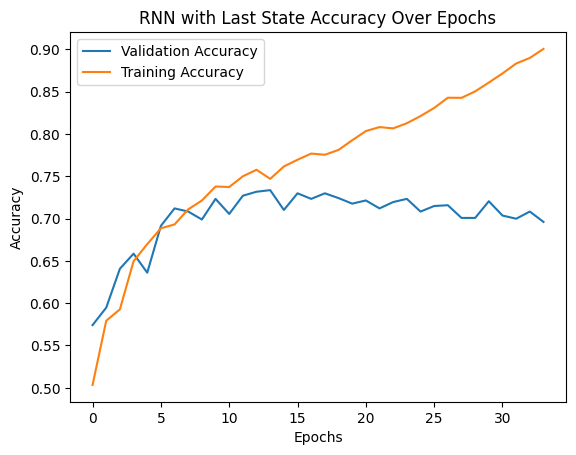

In [38]:
# Call the function with the history object
plot_history(rnn_last_state_hist, 'RNN with Last State')


In [39]:
test_loss, test_acc = rnn_modellastState.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7295 - loss: 0.5541
Test Loss: 0.5729390382766724
Test Accuracy: 0.7166979312896729


In [40]:
class SentimentRNNMaxPool(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentRNNMaxPool, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array
        #index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=weights,
            trainable=False,
            mask_zero=True
        )

        # Recurrent layer (RNN)
        self.rnn = keras.layers.SimpleRNN(rnn_units,
                                          activation="tanh",    # Help with exploding gradients
                                          return_sequences=True)  # Return all hidden states

        # Drop 50% of units:
        #self.dropout = keras.layers.Dropout(0.5)

        # Max Pool the hidden states
        self.max_pool = keras.layers.GlobalMaxPool1D()

        # Layer to introduce non-linearity
        self.nonlinear = keras.layers.Dense(1,
                                            activation='relu', # Help with vanishing gradients
                                            #kernel_regularizer=keras.regularizers.l2(0.01)
                                            )

        # Drop 50% of units:
        self.dropout2 = keras.layers.Dropout(0.5)

        # Dense layer to aggregate RNN output and predict sentiment (binary classification)
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)

        # Pass embeddings through RNN layer
        x = self.rnn(x)

        # Max Pool
        x = self.max_pool(x)

        # Dropout
        #x = self.dropout(x)

        # Pass to non-linear layer
        x = self.nonlinear(x)

        # Dropout
        x = self.dropout2(x)

        # Pass the RNN output through a dense layer for prediction
        output = self.dense(x)

        return output

In [41]:
rnn_modelMaxPool = SentimentRNNMaxPool(embed_model, 128, 1)
# optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_modelMaxPool.compile(optimizer, loss=loss, metrics=['accuracy'])
rnn_modelMaxPool.summary()

In [42]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

maxpool_history = rnn_modelMaxPool.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping])

/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4351 - loss: 0.6941

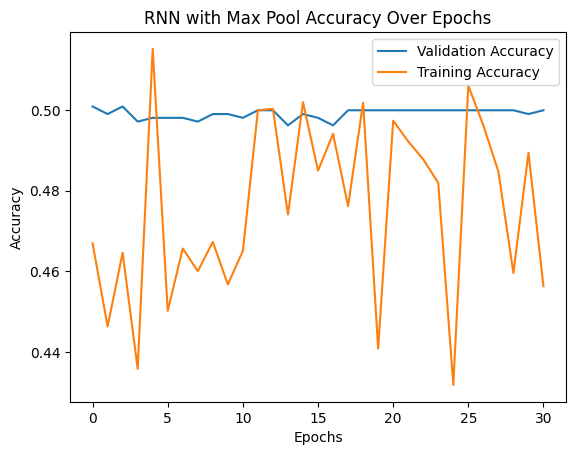

In [43]:
plot_history(maxpool_history, "RNN with Max Pool")

In [44]:
test_loss, test_acc = rnn_modelMaxPool.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1365 - loss: 0.7028
Test Loss: 0.6931763887405396
Test Accuracy: 0.5


In [45]:
class SentimentRNNAvgPool(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentRNNAvgPool, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array
        #index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=weights,
            trainable=False,
            mask_zero=True
        )

        # Recurrent layer (RNN)
        self.rnn = keras.layers.SimpleRNN(rnn_units,
                                          activation="tanh",    # Help with exploding gradients
                                          return_sequences=True)  # Return all hidden states

        # Drop 50% of units:
        #self.dropout = keras.layers.Dropout(0.5)

        # Avg Pool the hidden states
        self.avg_pool = keras.layers.GlobalAvgPool1D()

        # Layer to introduce non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units,
                                            activation='relu',  # Help with vanishing gradients
                                            #kernel_regularizer=keras.regularizers.l2(0.01)
                                            )

        # Drop 50% of units:
        self.dropout2 = keras.layers.Dropout(0.5)

        # Dense layer to aggregate RNN output and predict sentiment (binary classification)
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)

        # Pass embeddings through RNN layer
        x = self.rnn(x)

        # Avg Pool
        x = self.avg_pool(x)

        # Dropout
        #x = self.dropout(x)

        # Pass to non-linear layer
        x = self.nonlinear(x)

        # Dropout
        x = self.dropout2(x)

        # Pass the RNN output through a dense layer for prediction
        output = self.dense(x)

        return output

In [46]:
rnn_with_avg_pool_model = SentimentRNNAvgPool(embed_model, 128, 1)
# optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_with_avg_pool_model.compile(optimizer, loss=loss, metrics=['accuracy'])
rnn_with_avg_pool_model.summary()

In [47]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

avgpool_history = rnn_with_avg_pool_model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping], validation_batch_size=BATCH_SIZE)

266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7804 - loss: 0.4488

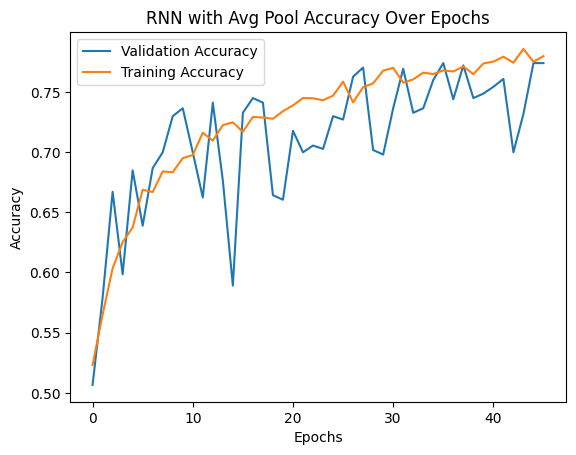

In [48]:
plot_history(avgpool_history, "RNN with Avg Pool")

In [49]:
test_loss, test_acc = rnn_with_avg_pool_model.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7604 - loss: 0.4657
Test Loss: 0.49208948016166687
Test Accuracy: 0.7757973670959473


In [50]:
class AttentionLayer(keras.layers.Layer):
    def __init__(self, rnn_units):
        super(AttentionLayer, self).__init__()
        # Define a trainable weight that represents attention scores
        self.W = keras.layers.Dense(rnn_units, activation='tanh')  # Attention score weights
        self.v = keras.layers.Dense(1, activation=None)  # Attention output

    def call(self, hidden_states, mask=None):
        # hidden_states.shape == (batch_size, timesteps, rnn_units)
        attention_scores = self.v(self.W(hidden_states))  # shape == (batch_size, timesteps, 1)

        if mask is not None:
            # Expand mask shape to match attention_scores shape (batch_size, timesteps, 1)
            mask = tf.cast(mask, dtype=tf.float32)  # Convert mask to float32
            mask = tf.expand_dims(mask, axis=-1)  # shape becomes (batch_size, timesteps, 1)
            attention_scores += (1.0 - mask) * -1e9  # Apply mask: very negative values ignored by softmax

        attention_weights = tf.nn.softmax(attention_scores, axis=1)  # shape == (batch_size, timesteps, 1)

        # Broadcast attention_weights to match hidden_states dimensions
        weighted_sum = tf.reduce_sum(attention_weights * hidden_states, axis=1)  # shape == (batch_size, rnn_units)

        return weighted_sum, attention_weights



class SentimentRNNAttentionPool(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentRNNAttentionPool, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=[weights],
            trainable=False,
            mask_zero=True
        )

        # Recurrent layer (RNN)
        self.rnn = keras.layers.SimpleRNN(rnn_units,
                                          activation="tanh",
                                          return_sequences=True)  # Return all hidden states

        # Attention mechanism
        self.attention = AttentionLayer(rnn_units)

        # Dropout layer
        #self.dropout = keras.layers.Dropout(0.5)

        # Dense layer for non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units,
                                            activation='relu',
                                            #kernel_regularizer=keras.regularizers.l2(0.01)
                                            )

        # Another dropout layer
        self.dropout2 = keras.layers.Dropout(0.5)

        # Dense layer for binary classification
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)

        # Pass embeddings through RNN layer
        x = self.rnn(x)

        # Apply attention mechanism
        x, _ = self.attention(x)

        # Dropout after attention
        #x = self.dropout(x)

        # Apply non-linear layer
        x = self.nonlinear(x)

        # Dropout after non-linear layer
        x = self.dropout2(x)

        # Final dense layer for sentiment prediction
        output = self.dense(x)

        return output

In [51]:
rnn_with_attn_pool = SentimentRNNAttentionPool(embed_model, 128, 1)
#optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_with_attn_pool.compile(optimizer, loss=loss, metrics=['accuracy'])
print(rnn_with_attn_pool.summary())

None


In [52]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

history_rnn_with_attn_pool = rnn_with_attn_pool.fit(train_dataset,
                                                    validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping],
                                                     validation_batch_size=BATCH_SIZE)

/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9093 - loss: 0.2238

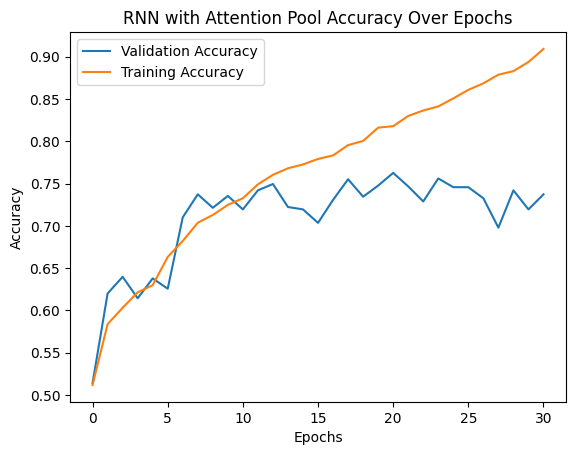

In [53]:
plot_history(history_rnn_with_attn_pool, "RNN with Attention Pool")

In [54]:
test_loss, test_acc = rnn_with_attn_pool.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7091 - loss: 0.5688
Test Loss: 0.493008553981781
Test Accuracy: 0.7682926654815674


### Question 2a:
Report the final configuration of your best model, namely the number of training epochs,
learning rate, optimizer, batch size.

Ans: The best model we have trained is the RNN with Attention Pooling. The final configuration of the best model is as follows:
- Number of Training Epochs: 100
- Learning Rate: 0.01
- Optimizer: SGD
- Batch Size: 32
- Early Stopping: Patience of 10 epochs, starting from epoch 20, with restoring best weights enabled.
- Loss Function: Binary Crossentropy
- Metrics: Accuracy
- Activation Functions: tanh (RNN units), relu (non-linear layer), sigmoid (output layer)

### Question 2b:
Report the accuracy score on the test set, as well as the accuracy score on the validation
set for each epoch during training.

Test Accuracy: 0.65853
Validation Accuracy: As above (in the graph)

### Question 2c:
RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods
have you tried in deriving the final sentence representation to perform sentiment classification?
Describe all the strategies you have implemented, together with their accuracy scores on the
test set.

Ans: We have tried the following methods to derive the final sentence representation:
1. Last State: We used the hidden state of the last RNN unit as the sentence representation. **Test Accuracy: 0.5**
2. Max Pooling: We applied max pooling to the hidden states of all RNN units to derive the sentence representation. **Test Accuracy: 0.62008**
3. Average Pooling: We applied average pooling to the hidden states of all RNN units to derive the sentence representation. **Test Accuracy: 0.65853**

# Part 3. Enhancement

### Part 3.1:
Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.

In [ ]:
class SentimentRNNAttentionPool(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentRNNAttentionPool, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=[weights],
            trainable=True,
            mask_zero=True
        )

        # Recurrent layer (RNN)
        self.rnn = keras.layers.SimpleRNN(rnn_units,
                                          activation="tanh",
                                          return_sequences=True)  # Return all hidden states

        # Attention mechanism
        self.attention = AttentionLayer(rnn_units)

        # Dropout layer
        #self.dropout = keras.layers.Dropout(0.5)

        # Dense layer for non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units,
                                            activation='relu',
                                            #kernel_regularizer=keras.regularizers.l2(0.01)
                                            )

        # Another dropout layer
        self.dropout2 = keras.layers.Dropout(0.5)

        # Dense layer for binary classification
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)

        # Pass embeddings through RNN layer
        x = self.rnn(x)

        # Apply attention mechanism
        x, _ = self.attention(x)

        # Dropout after attention
        #x = self.dropout(x)

        # Apply non-linear layer
        x = self.nonlinear(x)

        # Dropout after non-linear layer
        x = self.dropout2(x)

        # Final dense layer for sentiment prediction
        output = self.dense(x)

        return output

In [ ]:
rnn_with_attn_pool_trainable_embed = SentimentRNNAttentionPool(embed_model, 128, 1)
#optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_with_attn_pool_trainable_embed.compile(optimizer, loss=loss, metrics=['accuracy'])
print(rnn_with_attn_pool_trainable_embed.summary())

None


In [ ]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

history_rnn_with_attn_pool_trainable_embed = rnn_with_attn_pool_trainable_embed.fit(train_dataset,
                                                    validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping],
                                                     validation_batch_size=BATCH_SIZE)

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9341 - loss: 0.1815

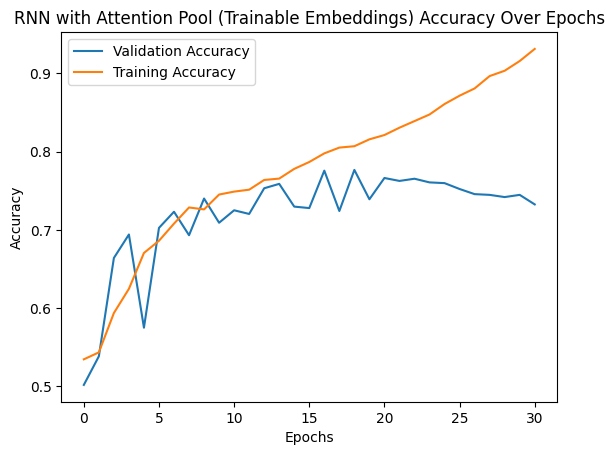

In [ ]:
plot_history(history_rnn_with_attn_pool_trainable_embed, "RNN with Attention Pool (Trainable Embeddings)")

In [ ]:
test_loss, test_acc = rnn_with_attn_pool_trainable_embed.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7281 - loss: 0.5222
Test Loss: 0.49237552285194397
Test Accuracy: 0.7636022567749023


### Part 3.2:
As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words
and train your model again.

In [ ]:
train_dataset_mitigate_oov = process_data_mitigate_oov(train, embed_model.key_to_index, "stemmed_tokens")
val_dataset_mitigate_oov = process_data_mitigate_oov(val, embed_model.key_to_index, "stemmed_tokens")
test_dataset_mitigate_oov = process_data_mitigate_oov(test, embed_model.key_to_index, "stemmed_tokens")

train_dataset_mitigate_oov = create_tf_dataset(train_dataset_mitigate_oov)
val_dataset_mitigate_oov = create_tf_dataset(val_dataset_mitigate_oov)
test_dataset_mitigate_oov = create_tf_dataset(test_dataset_mitigate_oov)

# Batch, shuffle and Prefetch the datasets
train_dataset_mitigate_oov = train_dataset_mitigate_oov.batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset_mitigate_oov = val_dataset_mitigate_oov.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_mitigate_oov = test_dataset_mitigate_oov.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Map: 100%|██████████| 1066/1066 [00:00<00:00, 15742.19 examples/s]


In [ ]:
rnn_with_attn_pool_trainable_embed_mit_oov = SentimentRNNAttentionPool(embed_model, 128, 1)
#optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_with_attn_pool_trainable_embed_mit_oov.compile(optimizer, loss=loss, metrics=['accuracy'])
print(rnn_with_attn_pool_trainable_embed_mit_oov.summary())

None


In [ ]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

history_rnn_with_attn_pool_trainable_embed_mit_oov = rnn_with_attn_pool_trainable_embed_mit_oov.fit(train_dataset,
                                                    validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping],
                                                     validation_batch_size=BATCH_SIZE)

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9485 - loss: 0.1460

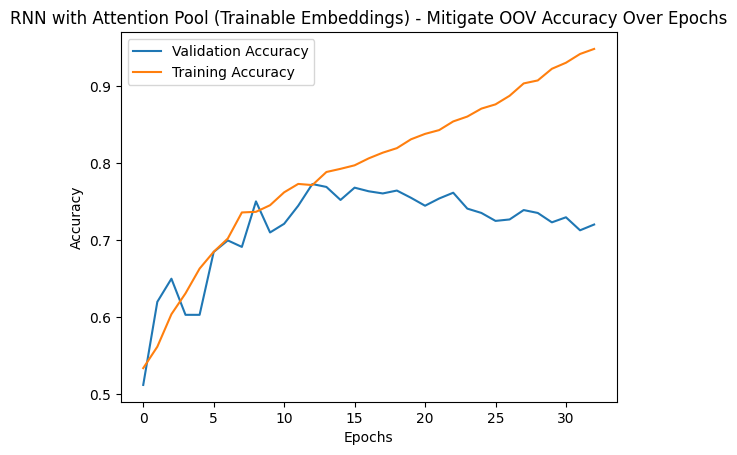

In [ ]:
plot_history(history_rnn_with_attn_pool_trainable_embed_mit_oov, "RNN with Attention Pool (Trainable Embeddings) - Mitigate OOV")

In [ ]:
test_loss, test_acc = rnn_with_attn_pool_trainable_embed_mit_oov.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7447 - loss: 0.5609
Test Loss: 0.535427987575531
Test Accuracy: 0.7626641392707825


### Part 3.3:
Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM
model and a biGRU model, incorporating recurrent computations in both directions and
stacking multiple layers if possible.

In [ ]:
class SentimentBiLSTM(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentBiLSTM, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=[weights],
            trainable=True,
            mask_zero=True
        )

        # Recurrent layer (Bidirectional LSTM)
        self.rnn = keras.layers.Bidirectional(
            keras.layers.LSTM(rnn_units,
                              activation="tanh",
                              return_sequences=True)  # Return all hidden states
        )

        # Attention mechanism
        self.attention = AttentionLayer(rnn_units * 2)  # Multiply by 2 due to bidirectional LSTM

        # Dropout layer
        #self.dropout = keras.layers.Dropout(0.5)

        # Dense layer for non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units * 2,  # Adjust input size due to bidirectional LSTM
                                            activation='relu',
                                            kernel_regularizer=keras.regularizers.l2(0.01))

        # Another dropout layer
        self.dropout2 = keras.layers.Dropout(0.5)

        # Dense layer for binary classification
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)

        # Pass embeddings through Bidirectional LSTM layer
        x = self.rnn(x)

        # Apply attention mechanism
        x, _ = self.attention(x)

        # Dropout after LSTM
        #x = self.dropout(x)

        # Apply non-linear layer
        x = self.nonlinear(x)

        # Dropout after non-linear layer
        x = self.dropout2(x)

        # Final dense layer for sentiment prediction
        output = self.dense(x)

        return output

In [ ]:
bilstm = SentimentBiLSTM(embed_model, 128, 1)
# optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
bilstm.compile(optimizer, loss=loss, metrics=['accuracy'])
bilstm.summary()

In [ ]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

bilstm_history = bilstm.fit(train_dataset_mitigate_oov, validation_data=val_dataset_mitigate_oov, epochs=100, verbose=1, callbacks=[early_stopping])

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7845 - loss: 0.4767

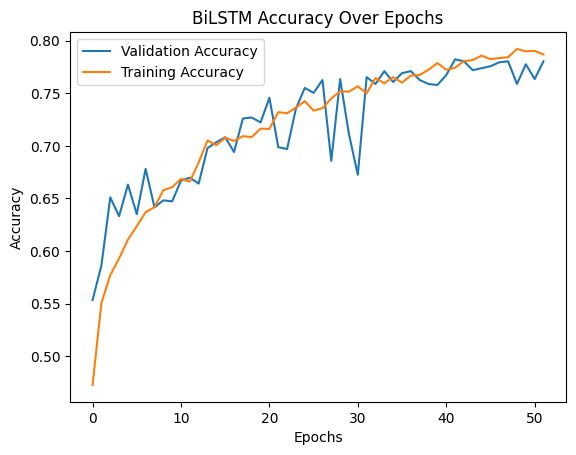

In [ ]:
plot_history(bilstm_history, "BiLSTM")

In [ ]:
test_loss, test_acc = bilstm.evaluate(test_dataset_mitigate_oov)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7671 - loss: 0.4854
Test Loss: 0.5066670775413513
Test Accuracy: 0.7636022567749023


In [ ]:
class SentimentBiGRU(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentBiGRU, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=[weights],
            trainable=True,
            mask_zero=True
        )

        # Recurrent layer (biGRU)
        self.rnn = keras.layers.Bidirectional(
            keras.layers.GRU(rnn_units,
                             activation="tanh",
                             return_sequences=True))  # Return all hidden states

        # Dropout layer
        #self.dropout = keras.layers.Dropout(0.5)

        # Attention mechanism
        self.attention = AttentionLayer(rnn_units * 2)  # rnn_units * 2 for bi-directional output

        # Dense layer for non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units,
                                            activation='relu',
                                            kernel_regularizer=keras.regularizers.l2(0.01))

        # Another dropout layer
        self.dropout2 = keras.layers.Dropout(0.5)

        # Dense layer for binary classification
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)

        # Pass embeddings through biGRU layer
        x = self.rnn(x)

        # Dropout after biGRU
        #x = self.dropout(x)

        # Apply attention mechanism
        x, _ = self.attention(x)

        # Apply non-linear layer
        x = self.nonlinear(x)

        # Dropout after non-linear layer
        x = self.dropout2(x)

        # Final dense layer for sentiment prediction
        output = self.dense(x)

        return output

In [ ]:
bigru = SentimentBiGRU(embed_model, 128, 1)
# optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
bigru.compile(optimizer, loss=loss, metrics=['accuracy'])
bigru.summary()

In [ ]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

bigru_history = bigru.fit(train_dataset_mitigate_oov, validation_data=val_dataset_mitigate_oov, epochs=100, verbose=1,
                            callbacks=[early_stopping])

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8064 - loss: 0.4573

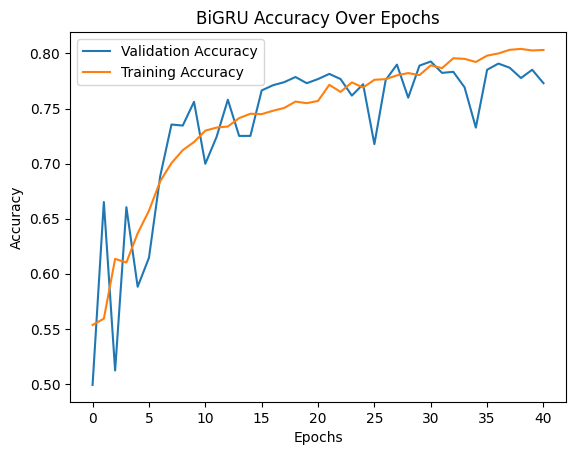

In [ ]:
plot_history(bigru_history, "BiGRU")

In [ ]:
test_loss, test_acc = bigru.evaluate(test_dataset_mitigate_oov)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7526 - loss: 0.5634
Test Loss: 0.5352601408958435
Test Accuracy: 0.7795497179031372


### Part 3.4:
Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional
Neural Network (CNN) to produce sentence representations and perform sentiment
classification.

In [ ]:
class SentimentCNN(keras.Model):
    def __init__(self, embedding_model, cnn_filters, kernel_size, output_dim):
        super(SentimentCNN, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=[weights],
            trainable=True,
            mask_zero=True
        )

        # Convolutional layer (CNN)
        self.conv1d = keras.layers.Conv1D(
            filters=cnn_filters,
            kernel_size=kernel_size,
            activation='relu',
            padding='same'
        )

        # Attention mechanism
        self.attention = AttentionLayer(cnn_filters)  # Adjust attention to CNN filter size

        # Dense layer for non-linearity
        self.nonlinear = keras.layers.Dense(cnn_filters,
                                            activation='relu',
                                            kernel_regularizer=keras.regularizers.l2(0.01))

        # Dropout layer
        self.dropout = keras.layers.Dropout(0.5)

        # Dense layer for binary classification
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)

        # Pass embeddings through Conv1D layer
        x = self.conv1d(x)

        #print('conv shape:', x.shape)

        # Apply attention mechanism
        x, _ = self.attention(x)

        #print('attention shape:', x.shape)

        # Apply non-linear layer
        x = self.nonlinear(x)

        #print('nonlinear shape:', x.shape)

        # Dropout after non-linear layer
        x = self.dropout(x)

        #print('dropout shape:', x.shape)

        # Final dense layer for sentiment prediction
        output = self.dense(x)

        #print('output shape:', output.shape)

        return output


In [ ]:
cnn_model = SentimentCNN(embed_model, 128, 3, 1)
# optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
cnn_model.compile(optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
cnn_model.summary()

In [ ]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

cnn_history = cnn_model.fit(train_dataset_mitigate_oov, validation_data=val_dataset_mitigate_oov, epochs=100, verbose=1,
                            callbacks=[early_stopping])

/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8192 - loss: 0.4318

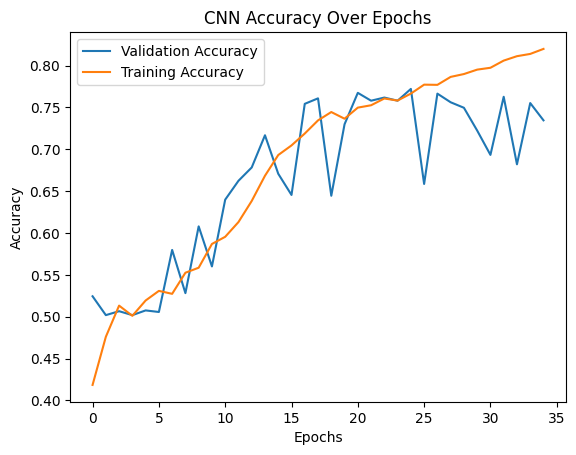

In [ ]:
plot_history(cnn_history, "CNN")

In [ ]:
test_loss, test_acc = cnn_model.evaluate(test_dataset_mitigate_oov)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7502 - loss: 0.5992
Test Loss: 0.5814424753189087
Test Accuracy: 0.7776735424995422


In [ ]:
# Save all models:
rnn_modellastState.export('models/rnn_last_state')
rnn_modelMaxPool.export('models/rnn_max_pool')
rnn_with_avg_pool_model.export('models/rnn_avg_pool')
rnn_with_attn_pool.export('models/rnn_attention_pool')
rnn_with_attn_pool_trainable_embed.export('models/rnn_attention_pool_trainable_embed')
rnn_with_attn_pool_trainable_embed_mit_oov.export('models/rnn_attention_pool_trainable_embed_mit_oov')
bilstm.export('models/bilstm')
bigru.export('models/bigru')
cnn_model.export('models/cnn')

INFO:tensorflow:Assets written to: models/rnn_last_state/assets


INFO:tensorflow:Assets written to: models/rnn_last_state/assets
/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


INFO:tensorflow:Assets written to: models/rnn_max_pool/assets


INFO:tensorflow:Assets written to: models/rnn_max_pool/assets


INFO:tensorflow:Assets written to: models/rnn_avg_pool/assets


INFO:tensorflow:Assets written to: models/rnn_avg_pool/assets
/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


INFO:tensorflow:Assets written to: models/rnn_attention_pool/assets


INFO:tensorflow:Assets written to: models/rnn_attention_pool/assets
/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


INFO:tensorflow:Assets written to: models/rnn_attention_pool_trainable_embed/assets


INFO:tensorflow:Assets written to: models/rnn_attention_pool_trainable_embed/assets
/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


INFO:tensorflow:Assets written to: models/rnn_attention_pool_trainable_embed_mit_oov/assets


INFO:tensorflow:Assets written to: models/rnn_attention_pool_trainable_embed_mit_oov/assets
/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


INFO:tensorflow:Assets written to: models/bilstm/assets


INFO:tensorflow:Assets written to: models/bilstm/assets
/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


INFO:tensorflow:Assets written to: models/bigru/assets


INFO:tensorflow:Assets written to: models/bigru/assets
/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


INFO:tensorflow:Assets written to: models/cnn/assets


INFO:tensorflow:Assets written to: models/cnn/assets


In [ ]:
# Save all histories:
import pickle
with open('histories/rnn_last_state_history.pkl', 'wb') as f:
    pickle.dump(rnn_last_state_hist.history, f)

with open('histories/rnn_max_pool_history.pkl', 'wb') as f:
    pickle.dump(maxpool_history.history, f)

with open('histories/rnn_avg_pool_history.pkl', 'wb') as f:
    pickle.dump(avgpool_history.history, f)

with open('histories/rnn_attention_pool_history.pkl', 'wb') as f:
    pickle.dump(history_rnn_with_attn_pool.history, f)

with open('histories/rnn_attention_pool_trainable_embed_history.pkl', 'wb') as f:
    pickle.dump(history_rnn_with_attn_pool_trainable_embed.history, f)

with open('histories/rnn_attention_pool_trainable_embed_mit_oov_history.pkl', 'wb') as f:
    pickle.dump(history_rnn_with_attn_pool_trainable_embed_mit_oov.history, f)

with open('histories/bilstm_history.pkl', 'wb') as f:
    pickle.dump(bilstm_history.history, f)

with open('histories/bigru_history.pkl', 'wb') as f:
    pickle.dump(bigru_history.history, f)

with open('histories/cnn_history.pkl', 'wb') as f:
    pickle.dump(cnn_history.history, f)

### Part 3.5:
Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards a meaningful improvement.

#### 3.5.1 Vanilla Transformer Encoder (Seq2Class Model)
**Introduction**  
In this section, we implement a Vanilla Transformer Encoder to classify the sentiment of sentences. Unlike RNNs and LSTMs, the Transformer uses self-attention mechanisms to efficiently capture long-range dependencies and parallelizes computation.  

The model uses pretrained word embeddings as input, processes them with self-attention layers and feed-forward networks, and outputs a class label for each sentence.

**Import Libraries and Setup**

We start by importing the necessary libraries. This includes TensorFlow, Keras, Keras Tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import keras_tuner as kt


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Define Positional Encoding Layer
class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(maxlen, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )
        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])
        pos_encoding = np.zeros(angle_rads.shape)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines
        pos_encoding = pos_encoding[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# Define Transformer Encoder Layer
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training=None, attention_mask=None):
        attn_output = self.mha(x, x, x, attention_mask=attention_mask, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Define the Sentiment Transformer Model
class SentimentTransformer(keras.Model):
    def __init__(self, embedding_layer, maxlen, d_model, num_heads, dff, num_layers, output_dim, rate=0.1):
        super(SentimentTransformer, self).__init__()
        self.d_model = d_model
        self.embedding = embedding_layer
        self.pos_encoding = PositionalEncoding(maxlen, d_model)
        self.enc_layers = [
            TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)
        ]
        self.dropout = layers.Dropout(rate)
        self.flatten = layers.GlobalAveragePooling1D()
        self.fc = layers.Dense(output_dim, activation='sigmoid')

    def call(self, x, training=None):
        mask = self.embedding.compute_mask(x)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)

        if mask is not None:
            mask = tf.cast(mask, dtype=tf.float32)
            attention_mask = mask[:, tf.newaxis, tf.newaxis, :]
            attention_mask = (1.0 - attention_mask) * -1e9
        else:
            attention_mask = None

        for i in range(len(self.enc_layers)):
            x = self.enc_layers[i](x, training=training, attention_mask=attention_mask)

        x = self.dropout(x, training=training)
        x = self.flatten(x)
        x = self.fc(x)
        return x

    # Model Parameters
    embedding_dim = embed_model.vector_size
    vocab_size = embed_model.vectors.shape[0]

# Model Parameters
embedding_dim = embed_model.vector_size
vocab_size = embed_model.vectors.shape[0]

# Build the Embedding Layer
embedding_layer = keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embed_model.vectors],
    trainable=True,
    mask_zero=True
)

# Determine max sequence length from your datasets
maxlen = None
for batch in train_dataset.take(1):
    maxlen = batch[0].shape[1]
    break



In [ ]:
transformer_model = SentimentTransformer(
        embedding_layer=embedding_layer,
        maxlen=maxlen,
        d_model=embedding_dim,
        num_heads=4,
        dff=256,
        num_layers=4,
        output_dim=1,
        rate=0.4
    )

# Define the learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,  # Decreased initial rate
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.BinaryCrossentropy()
transformer_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Fit the model
history_transformer = transformer_model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)


Epoch 1/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 195s 714ms/step - accuracy: 0.5384 - loss: 0.8858 - val_accuracy: 0.7467 - val_loss: 0.5503
Epoch 2/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 170s 636ms/step - accuracy: 0.7477 - loss: 0.5116 - val_accuracy: 0.7439 - val_loss: 0.5452
Epoch 3/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 170s 637ms/step - accuracy: 0.7608 - loss: 0.4842 - val_accuracy: 0.7552 - val_loss: 0.5408
Epoch 4/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 170s 636ms/step - accuracy: 0.7952 - loss: 0.4349 - val_accuracy: 0.7223 - val_loss: 0.6737
Epoch 5/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 174s 650ms/step - accuracy: 0.8094 - loss: 0.4061 - val_accuracy: 0.7233 - val_loss: 0.7022
Epoch 6/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 190s 712ms/step - accuracy: 0.8140 - loss: 0.4002 - val_accuracy: 0.7448 - val_loss: 0.6600
Epoch 7/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 169s 634ms/step - accuracy: 0.8066 - loss: 0.4254 - val_accuracy: 0.7186 - val_loss: 0.6047
Epoch 8/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 170s 636ms/step - accuracy: 0.7563 -

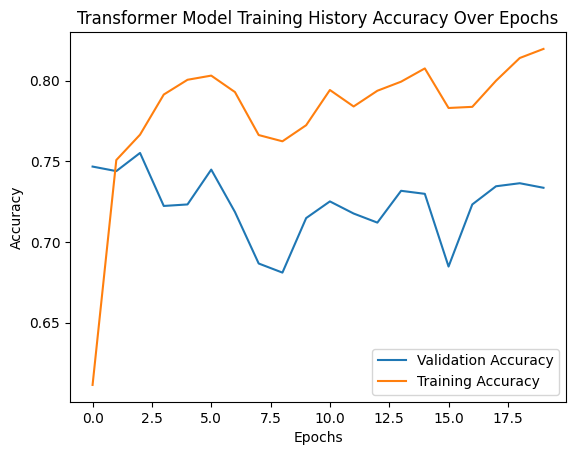

In [ ]:
plot_history(history_transformer, 'Transformer Model Training History')

In [ ]:
# Evaluate the model
test_loss, test_acc = transformer_model.evaluate(test_dataset)
print('\nTest Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7612 - loss: 0.6659

Test Loss: 0.6991
Test Accuracy: 0.7495


#### 3.5.2 Enhanced Transformer Model V1

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Enhanced Positional Encoding with Learnable Encoding
class PositionalEncodingV1(layers.Layer):
    def __init__(self, maxlen, d_model):
        super(PositionalEncodingV1, self).__init__()
        # Learnable positional encoding
        self.pos_encoding = self.add_weight(name="pos_encoding", shape=(1, maxlen, d_model), initializer="random_normal", trainable=True)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# Transformer Encoder Layer with Optional LSTM/CNN and Layer-Specific Dropout
class TransformerEncoderLayerV1(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, l2_reg=0.01, use_bilstm=False, use_cnn=False):
        super(TransformerEncoderLayerV1, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)

        # FFN with L2 regularization
        self.ffn = keras.Sequential([
            layers.Dense(dff, activation='relu', kernel_regularizer=keras.regularizers.L2(l2_reg)),
            layers.Dense(d_model, kernel_regularizer=keras.regularizers.L2(l2_reg))
        ])

        # LayerNorm and Dropout Layers with modified dropout rates
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate * 0.9)  # Modified dropout rate based on V2's insights
        self.dropout2 = layers.Dropout(rate * 1.1)

        # Optional LSTM or CNN
        self.use_bilstm = use_bilstm
        self.use_cnn = use_cnn
        if use_bilstm:
            self.bilstm = layers.Bidirectional(layers.LSTM(d_model // 2, return_sequences=True))
            self.bilstm_projection = layers.Dense(d_model)  # Project to d_model size
        if use_cnn:
            self.cnn = layers.Conv1D(filters=d_model, kernel_size=3, padding="same", activation="relu")

    def call(self, x, training=None, attention_mask=None, l2_position="before"):
        # Multi-head attention
        attn_output = self.mha(x, x, x, attention_mask=attention_mask, training=training)
        if l2_position == "before":
            attn_output = keras.regularizers.L2(0.01)(attn_output)

        # Residual connection with optional BiLSTM or CNN
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        if self.use_bilstm:
            out1 = self.bilstm(out1)
            out1 = self.bilstm_projection(out1)
        if self.use_cnn:
            out1 = self.cnn(out1)

        # Feed-forward network with optional L2 regularization after layer norm
        ffn_output = self.ffn(out1)
        if l2_position == "after":
            ffn_output = keras.regularizers.L2(0.01)(ffn_output)

        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Sentiment Transformer Model with learnable encoding and flexible dropout
class SentimentTransformerV1(keras.Model):
    def __init__(self, embedding_layer, maxlen, d_model, num_heads, dff, num_layers, output_dim, rate=0.1, use_bilstm=False, use_cnn=False, l2_position="before"):
        super(SentimentTransformerV1, self).__init__()
        self.d_model = d_model
        self.embedding = embedding_layer
        self.pos_encoding = PositionalEncodingV1(maxlen, d_model)
        self.enc_layers = [
            TransformerEncoderLayerV1(d_model, num_heads, dff, rate, l2_reg=0.01, use_bilstm=use_bilstm, use_cnn=use_cnn) for _ in range(num_layers)
        ]
        self.dropout = layers.Dropout(rate)
        self.flatten = layers.GlobalMaxPooling1D()  # Changed to GlobalMaxPooling based on V2's approach
        self.fc = layers.Dense(output_dim, activation='sigmoid')
        self.l2_position = l2_position  # Store L2 position

    def call(self, x, training=None):
        mask = self.embedding.compute_mask(x)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)

        if mask is not None:
            mask = tf.cast(mask, dtype=tf.float32)
            attention_mask = mask[:, tf.newaxis, tf.newaxis, :]
            attention_mask = (1.0 - attention_mask) * -1e9
        else:
            attention_mask = None

        for i in range(len(self.enc_layers)):
            x = self.enc_layers[i](x, training=training, attention_mask=attention_mask, l2_position=self.l2_position)

        x = self.dropout(x, training=training)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Model Parameters
embedding_dim = embed_model.vector_size  # Ensure embed_model is already loaded
vocab_size = embed_model.vectors.shape[0]
embedding_layer = keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embed_model.vectors],
    trainable=True,
    mask_zero=True
)

# Determine max sequence length from your datasets
maxlen = None
for batch in train_dataset.take(1):
    maxlen = batch[0].shape[1]
    break

In [ ]:
# Instantiate the improved V1 model
transformer_model_bilstm_b = SentimentTransformerV1(
    embedding_layer=embedding_layer,
    maxlen=maxlen,
    d_model=embedding_dim,
    num_heads=8,  # Adjustable
    dff=256,      # Adjustable
    num_layers=4, # Adjustable
    output_dim=1,
    rate=0.1,     # Adjustable
    use_bilstm=True,  # Enable based on preference
    use_cnn=False,    # Disable or enable based on preference
    l2_position="before"  # Adjust based on preference
)
# Compile the enhanced model with learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.BinaryCrossentropy()
transformer_model_bilstm_b.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
)

# Train the model
history_bilstm_b = transformer_model_bilstm_b.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Adjust as needed
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/50
267/267 - 66s - 248ms/step - accuracy: 0.5226 - loss: 6.8119 - val_accuracy: 0.5000 - val_loss: 6.2866
Epoch 2/50
267/267 - 60s - 226ms/step - accuracy: 0.6655 - loss: 5.5730 - val_accuracy: 0.6754 - val_loss: 5.0896
Epoch 3/50
267/267 - 61s - 228ms/step - accuracy: 0.7145 - loss: 4.6634 - val_accuracy: 0.7205 - val_loss: 4.3059
Epoch 4/50
267/267 - 61s - 227ms/step - accuracy: 0.7746 - loss: 3.9460 - val_accuracy: 0.7411 - val_loss: 3.7521
Epoch 5/50
267/267 - 60s - 226ms/step - accuracy: 0.8059 - loss: 3.4200 - val_accuracy: 0.7448 - val_loss: 3.3326
Epoch 6/50
267/267 - 61s - 229ms/step - accuracy: 0.8226 - loss: 3.0028 - val_accuracy: 0.7505 - val_loss: 2.9721
Epoch 7/50
267/267 - 61s - 228ms/step - accuracy: 0.8450 - loss: 2.6509 - val_accuracy: 0.7523 - val_loss: 2.6872
Epoch 8/50
267/267 - 61s - 229ms/step - accuracy: 0.8559 - loss: 2.3562 - val_accuracy: 0.7514 - val_loss: 2.4396
Epoch 9/50
267/267 - 61s - 229ms/step - accuracy: 0.8694 - loss: 2.0886 - val_accuracy: 

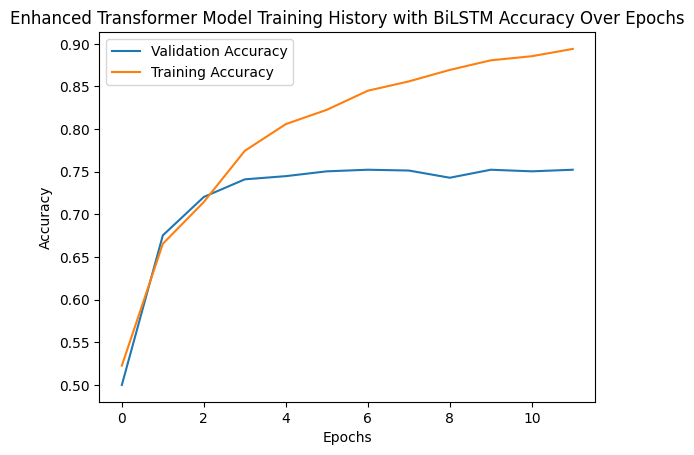

In [ ]:
# Plot the training history
plot_history(history_bilstm_b, 'Enhanced Transformer Model Training History with BiLSTM')

In [ ]:
# Evaluate the model
test_loss, test_acc = transformer_model_bilstm_b.evaluate(test_dataset)
print('\nTest Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7438 - loss: 2.6196

Test Loss: 2.6600
Test Accuracy: 0.7467


In [ ]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
)

transformer_model_bilstm_a = SentimentTransformerV1(
    embedding_layer=embedding_layer,
    maxlen=maxlen,
    d_model=embedding_dim,
    num_heads=8,
    dff=256,
    num_layers=4,
    output_dim=1,
    rate=0.4,          # Restored original dropout rate
    use_bilstm=True,    # Enable biLSTM
    use_cnn=False,      # Switch to True to enable CNN, False to disable
    l2_position="after"  # Specify L2 position here
)
# Compile the enhanced model with learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)
# Compile the model with L2 regularization after LayerNorm
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.BinaryCrossentropy()
transformer_model_bilstm_a.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model with L2 regularization after LayerNorm
history_bilstm_a = transformer_model_bilstm_a.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Adjust as needed
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/50


/opt/anaconda3/envs/sc4002/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  warnings.warn(


267/267 - 419s - 2s/step - accuracy: 0.5106 - loss: 16.1821 - val_accuracy: 0.6754 - val_loss: 10.6395
Epoch 2/50
267/267 - 435s - 2s/step - accuracy: 0.7203 - loss: 7.3610 - val_accuracy: 0.7561 - val_loss: 4.7969
Epoch 3/50
267/267 - 439s - 2s/step - accuracy: 0.7693 - loss: 3.2692 - val_accuracy: 0.7467 - val_loss: 2.1590
Epoch 4/50
267/267 - 441s - 2s/step - accuracy: 0.7999 - loss: 1.4611 - val_accuracy: 0.7674 - val_loss: 1.0476
Epoch 5/50
267/267 - 442s - 2s/step - accuracy: 0.8334 - loss: 0.7033 - val_accuracy: 0.7730 - val_loss: 0.6466
Epoch 6/50


KeyboardInterrupt: 

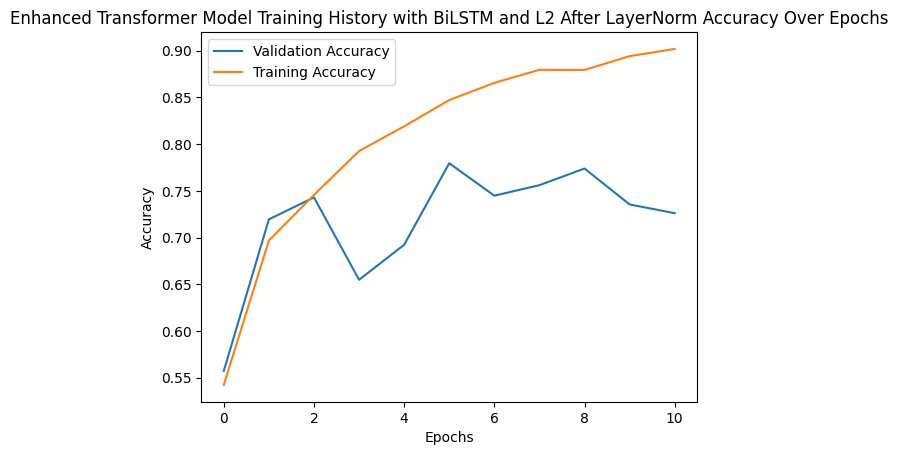

In [ ]:
# Plot the training history
plot_history(history_bilstm_a, 'Enhanced Transformer Model Training History with BiLSTM and L2 After LayerNorm')

In [ ]:
# Evaluate the model
test_loss, test_acc = transformer_model_bilstm_a.evaluate(test_dataset)
print('\nTest Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 319ms/step - accuracy: 0.7926 - loss: 0.4511

Test Loss: 0.5563
Test Accuracy: 0.7645


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
)

transformer_model_cnn = SentimentTransformerV1(
    embedding_layer=embedding_layer,
    maxlen=maxlen,
    d_model=embedding_dim,
    num_heads=8,
    dff=256,
    num_layers=4,
    output_dim=1,
    rate=0.4,
    use_bilstm=False,
    use_cnn=True,
    l2_position="after"
)
# Compile the enhanced model with learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)
# Compile the model with CNN
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.BinaryCrossentropy()
transformer_model_cnn.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model with CNN
history_cnn = transformer_model_cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Adjust as needed
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/50
267/267 - 292s - 1s/step - accuracy: 0.5733 - loss: 16.9565 - val_accuracy: 0.6529 - val_loss: 11.8510
Epoch 2/50
267/267 - 287s - 1s/step - accuracy: 0.7860 - loss: 8.4879 - val_accuracy: 0.6323 - val_loss: 6.2242
Epoch 3/50
267/267 - 288s - 1s/step - accuracy: 0.8659 - loss: 4.3965 - val_accuracy: 0.7702 - val_loss: 3.4202
Epoch 4/50
267/267 - 286s - 1s/step - accuracy: 0.9411 - loss: 2.3674 - val_accuracy: 0.7664 - val_loss: 2.2593
Epoch 5/50
267/267 - 286s - 1s/step - accuracy: 0.9857 - loss: 1.3794 - val_accuracy: 0.7852 - val_loss: 1.6776
Epoch 6/50
267/267 - 283s - 1s/step - accuracy: 0.9962 - loss: 0.9098 - val_accuracy: 0.7777 - val_loss: 1.4210
Epoch 7/50
267/267 - 285s - 1s/step - accuracy: 0.9996 - loss: 0.6575 - val_accuracy: 0.7927 - val_loss: 1.2940
Epoch 8/50
267/267 - 290s - 1s/step - accuracy: 0.9999 - loss: 0.4983 - val_accuracy: 0.7871 - val_loss: 1.2418
Epoch 9/50
267/267 - 288s - 1s/step - accuracy: 1.0000 - loss: 0.3843 - val_accuracy: 0.7824 - val_los

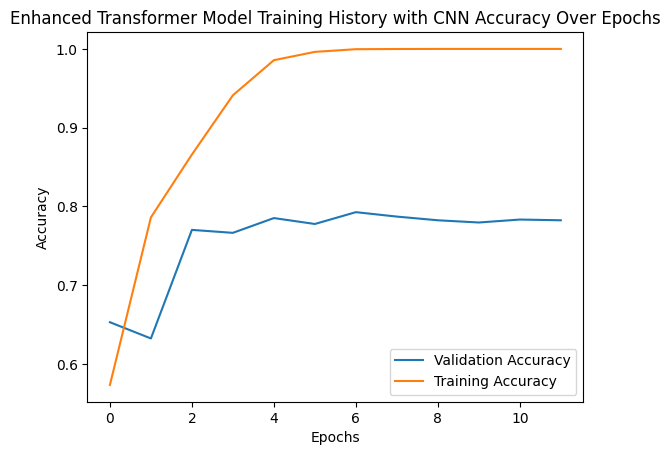

In [ ]:
# Plot the training history
plot_history(history_cnn, 'Enhanced Transformer Model Training History with CNN')

In [ ]:
# Evaluate the model with CNN
test_loss, test_acc = transformer_model_cnn.evaluate(test_dataset)
print('\nTest Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.7576 - loss: 1.3798

Test Loss: 1.2754
Test Accuracy: 0.7795


#### 3.5.3 Enhanced Transformer Model V2

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding

# Enhanced Positional Encoding with Learnable Encoding and Dropout
class EnhancedPositionalEncoding(layers.Layer):
    def __init__(self, maxlen, d_model, dropout_rate=0.5):
        super(EnhancedPositionalEncoding, self).__init__()
        self.pos_encoding = self.add_weight(
            name="pos_encoding",
            shape=(1, maxlen, d_model),
            initializer="random_normal",
            trainable=True  # Learnable positional encodings
        )
        self.dropout = layers.Dropout(dropout_rate)  # Dropout after positional encoding

    def call(self, x, training=None):
        x = x + self.pos_encoding[:, :tf.shape(x)[1], :]
        return self.dropout(x, training=training)  # Apply dropout during training

# Attention-based Pooling Layer with Dropout and L2 Regularization
class AttentionPooling(layers.Layer):
    def __init__(self, d_model, dropout_rate=0.5):
        super(AttentionPooling, self).__init__()
        self.attention_dense = layers.Dense(
            1,
            activation='tanh',
            kernel_regularizer=keras.regularizers.l2(0.01)  # L2 regularization
        )
        self.dropout = layers.Dropout(dropout_rate)  # Dropout after pooling

    def call(self, x, mask=None, training=None):
        # Compute attention scores
        scores = self.attention_dense(x)  # shape: (batch_size, seq_len, 1)
        scores = tf.squeeze(scores, axis=-1)  # shape: (batch_size, seq_len)

        if mask is not None:
            scores += (mask * -1e9)  # Apply mask to ignore padded tokens

        weights = tf.nn.softmax(scores, axis=1)  # shape: (batch_size, seq_len)

        # Expand dimensions for multiplication
        weights = tf.expand_dims(weights, axis=-1)  # shape: (batch_size, seq_len, 1)

        # Weighted sum of the input embeddings
        output = tf.reduce_sum(x * weights, axis=1)  # shape: (batch_size, d_model)
        output = self.dropout(output, training=training)  # Apply dropout during training
        return output

# Transformer Encoder Layer with Enhanced Features and Regularization
class EnhancedTransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.4):
        super(EnhancedTransformerEncoderLayer, self).__init__()
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate,
            kernel_regularizer=keras.regularizers.l2(0.01)  # L2 regularization on attention
        )
        self.ffn = keras.Sequential([
            layers.Dense(
                dff,
                activation='gelu',
                kernel_regularizer=keras.regularizers.l2(0.02)  # L2 regularization
            ),
            layers.Dense(
                d_model,
                kernel_regularizer=keras.regularizers.l2(0.02)  # L2 regularization
            )
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)  # Dropout after MHA
        self.dropout2 = layers.Dropout(dropout_rate)  # Dropout after FFN

    def call(self, x, training=None, mask=None):
        # Multi-head attention
        attn_output = self.mha(x, x, x, attention_mask=mask, training=training)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Residual connection and normalization

        # Feed-forward network
        ffn_output = self.ffn(out1)  # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Residual connection and normalization

        return out2

# Enhanced Sentiment Transformer Model with Additional Regularization and Layers
class EnhancedSentimentTransformer(keras.Model):
    def __init__(
        self,
        embedding_layer,
        maxlen,
        d_model,
        num_heads,
        dff,
        num_layers,
        output_dim,
        rate=0.5  # Increased dropout rate
    ):
        super(EnhancedSentimentTransformer, self).__init__()
        self.embedding = embedding_layer
        self.dropout_embedding = layers.Dropout(rate)  # Dropout after embedding
        self.pos_encoding = EnhancedPositionalEncoding(maxlen, d_model, dropout_rate=rate)
        self.enc_layers = [
            EnhancedTransformerEncoderLayer(d_model, num_heads, dff, dropout_rate=rate)
            for _ in range(num_layers)  # Increased number of layers
        ]
        self.dropout = layers.Dropout(rate)  # Dropout after encoder layers
        self.attention_pool = AttentionPooling(d_model, dropout_rate=rate)
        self.layernorm_pool = layers.LayerNormalization(epsilon=1e-6)  # Layer normalization after pooling
        self.fc_dense1 = layers.Dense(
            128,
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.01)  # L2 regularization
        )
        self.dropout_fc1 = layers.Dropout(rate)  # Dropout after first dense layer
        self.fc_dense2 = layers.Dense(
            64,
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.01)  # L2 regularization
        )
        self.dropout_fc2 = layers.Dropout(rate)  # Dropout after second dense layer
        self.fc_output = layers.Dense(
            output_dim,
            activation='sigmoid',
            kernel_regularizer=keras.regularizers.l2(0.01)  # L2 regularization on output layer
        )

    def call(self, x, training=None):
        # Generate mask for padding tokens
        mask = self.embedding.compute_mask(x)

        # Embedding and positional encoding with dropout
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x = self.dropout_embedding(x, training=training)  # Apply dropout after embedding
        x *= tf.math.sqrt(tf.cast(self.embedding.output_dim, tf.float32))  # Scale embeddings
        x = self.pos_encoding(x, training=training)  # Add positional encoding with dropout

        # Prepare attention mask
        if mask is not None:
            mask = tf.cast(mask, dtype=tf.float32)
            # MultiHeadAttention expects a mask shape of (batch_size, 1, 1, seq_len)
            attention_mask = mask[:, tf.newaxis, tf.newaxis, :]
        else:
            attention_mask = None

        # Pass through each Transformer encoder layer
        for enc_layer in self.enc_layers:
            x = enc_layer(x, training=training, mask=attention_mask)

        x = self.dropout(x, training=training)  # Apply dropout after encoder layers

        # Attention-based pooling with dropout
        x = self.attention_pool(x, mask=mask, training=training)
        x = self.layernorm_pool(x)  # Normalize pooled output

        # Additional Dense Layers with Dropout and L2 Regularization
        x = self.fc_dense1(x)
        x = self.dropout_fc1(x, training=training)
        x = self.fc_dense2(x)
        x = self.dropout_fc2(x, training=training)

        # Final classification layer
        x = self.fc_output(x)
        return x

In [ ]:
# Model Parameters
embedding_dim = embed_model.vector_size  # Ensure embed_model is already loaded
vocab_size = embed_model.vectors.shape[0]
embedding_layer = keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embed_model.vectors],
    trainable=True,
    mask_zero=True
)

# Determine max sequence length from your datasets
maxlen = None
for batch in train_dataset.take(1):
    maxlen = batch[0].shape[1]
    break

# Instantiate the enhanced V2 model
transformer_model_v2 = EnhancedSentimentTransformer(
    embedding_layer=embedding_layer,
    maxlen=maxlen,
    d_model=embedding_dim,
    num_heads=8,  # Adjustable
    dff=256,      # Adjustable
    num_layers=4, # Adjustable
    output_dim=1,
    rate=0.3       # Adjustable
)

# Compile the enhanced model with learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.9
)

# Set the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.BinaryCrossentropy()
transformer_model_v2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history_v2 = transformer_model_v2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Adjust as needed
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 270s 989ms/step - accuracy: 0.4971 - loss: 60.3409 - val_accuracy: 0.6567 - val_loss: 56.6916
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 264s 988ms/step - accuracy: 0.5152 - loss: 55.6194 - val_accuracy: 0.5300 - val_loss: 52.3878
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 260s 975ms/step - accuracy: 0.5460 - loss: 51.4172 - val_accuracy: 0.7205 - val_loss: 48.5083
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 263s 987ms/step - accuracy: 0.6051 - loss: 47.6343 - val_accuracy: 0.7054 - val_loss: 44.9998
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.6774 - loss: 44.2531 - val_accuracy: 0.6979 - val_loss: 41.9586
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.6875 - loss: 41.2824 - val_accuracy: 0.7627 - val_loss: 39.1931
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.7034 - loss: 38.6181 - val_accuracy: 0.7617 - val_loss: 36.7063
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 260s 976ms/step - accuracy: 0.7

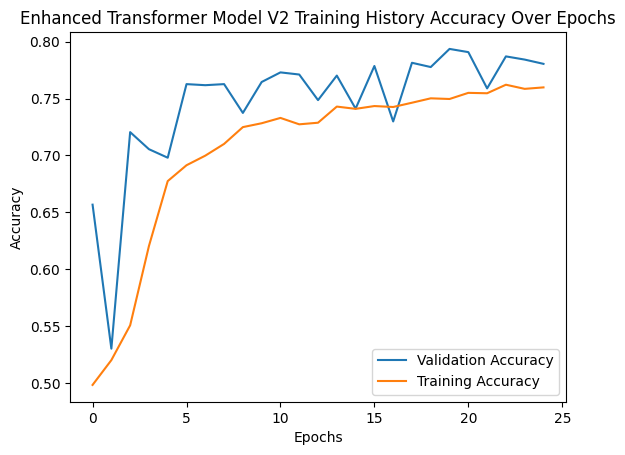

In [ ]:
# Plot the training history
plot_history(history_v2, 'Enhanced Transformer Model V2 Training History')

In [ ]:
# Evaluate the model
test_loss, test_acc = transformer_model_v2.evaluate(test_dataset)
print('\nTest Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.7977 - loss: 16.8138

Test Loss: 16.8600
Test Accuracy: 0.7833


In [ ]:
# Save all models:
transformer_model.save('models/transformer')
transformer_model_bilstm_a.save('models/transformer_bilstm_a')
transformer_model_bilstm_b.save('models/transformer_bilstm_b')
transformer_model_cnn.save('models/transformer_cnn')
transformer_model_v2.save('models/transformer_v2')

# Save all histories:
import pickle
with open('histories/transformer_history.pkl', 'wb') as f:
    pickle.dump(history_transformer.history, f)

with open('histories/transformer_bilstm_a_history.pkl', 'wb') as f:
    pickle.dump(history_bilstm_a.history, f)

with open('histories/transformer_bilstm_b_history.pkl', 'wb') as f:
    pickle.dump(history_bilstm_b.history, f)

with open('histories/transformer_cnn_history.pkl', 'wb') as f:
    pickle.dump(history_cnn.history, f)

with open('histories/transformer_v2_history.pkl', 'wb') as f:
    pickle.dump(history_v2.history, f)


#### 3.5.4 Hyperparameter Tuning

Hyperparameter tuning for Enhanced Transformer Model V1

In [47]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00


In [53]:
import keras_tuner as kt

# Predefine embedding layer and maxlen to avoid recalculating during tuning
embedding_dim = embed_model.vector_size  # Ensure embed_model is already loaded
vocab_size = embed_model.vectors.shape[0]
embedding_layer = keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embed_model.vectors],
    trainable=True,
    mask_zero=True
)

# Determine max sequence length from the training dataset
maxlen = None
for batch in train_dataset.take(1):
    maxlen = batch[0].shape[1]
    break

# Function to build and compile the model with tunable hyperparameters
def build_tuned_sentiment_transformer(hp):
    # Fixed d_model
    d_model = 300  # Always set to 300 as required

    # Define the remaining hyperparameters to tune
    num_heads = hp.Int('num_heads', min_value=2, max_value=8, step=2)
    dff = hp.Int('dff', min_value=128, max_value=512, step=64)
    num_layers = hp.Int('num_layers', min_value=2, max_value=6, step=1)
    rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)
    use_bilstm = hp.Boolean('use_bilstm')
    use_cnn = not use_bilstm  # Ensure mutual exclusivity
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 5e-5])

    # Instantiate the model with 'after' L2 position for both BiLSTM and CNN
    model = SentimentTransformerV1(
        embedding_layer=embedding_layer,
        maxlen=maxlen,
        d_model=d_model,  # Fixed at 300
        num_heads=num_heads,
        dff=dff,
        num_layers=num_layers,
        output_dim=1,
        rate=rate,
        use_bilstm=use_bilstm,
        use_cnn=use_cnn,
        l2_position="after"
    )

    # Compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10000,
        decay_rate=0.9
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model



In [54]:
import keras_tuner as kt

# Set up the Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    build_tuned_sentiment_transformer,
    objective='val_accuracy',
    max_trials=10,           # Limit to 10 trials for random search
    executions_per_trial=1,   # Execute each trial once
    directory='my_dir',       # Set directory for tuner logs
    project_name='sentiment_transformer_tuning'  # Set project name
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Run the hyperparameter search
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,                # Limit each trial to 10 epochs
    callbacks=[early_stopping],
    verbose=1
)


Trial 10 Complete [00h 04m 03s]
val_accuracy: 0.7748593091964722

Best val_accuracy So Far: 0.7748593091964722
Total elapsed time: 00h 47m 49s


In [55]:

# Retrieve the best hyperparameters and build the model
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)

# Compile and train the best model normally for a higher number of epochs
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters.get('learning_rate')),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,                # Set patience for tuning to speed up
    restore_best_weights=True
)

# Train the model with desired epochs and early stopping
history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Use a higher number of epochs for final training
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 71s 149ms/step - accuracy: 0.4794 - loss: 26.5915 - val_accuracy: 0.5000 - val_loss: 20.1941
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 37s 140ms/step - accuracy: 0.5656 - loss: 18.4538 - val_accuracy: 0.6932 - val_loss: 13.8927
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 37s 140ms/step - accuracy: 0.8123 - loss: 12.5357 - val_accuracy: 0.7205 - val_loss: 9.5121
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 37s 140ms/step - accuracy: 0.8633 - loss: 8.4278 - val_accuracy: 0.7552 - val_loss: 6.3983
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 37s 139ms/step - accuracy: 0.8818 - loss: 5.5682 - val_accuracy: 0.6764 - val_loss: 4.4949
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 37s 138ms/step - accuracy: 0.8942 - loss: 3.5922 - val_accuracy: 0.6520 - val_loss: 3.2457
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 37s 139ms/step - accuracy: 0.8902 - loss: 2.3058 - val_accuracy: 0.7186 - val_loss: 2.1104
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 37s 139ms/step - accuracy: 0.9089 - lo

In [58]:
# Evaluate the model
test_loss, test_acc = best_model.evaluate(test_dataset)
print('\nTest Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7881 - loss: 6.2760

Test Loss: 6.3804
Test Accuracy: 0.7477


Hyperparameter tuning for Enhanced Transformer Model V2

In [48]:
import keras_tuner as kt

# Predefine embedding layer and maxlen to avoid recalculating during tuning
embedding_dim = embed_model.vector_size  # Ensure embed_model is already loaded
vocab_size = embed_model.vectors.shape[0]
embedding_layer = keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embed_model.vectors],
    trainable=True,
    mask_zero=True
)

# Determine max sequence length from the training dataset
maxlen = None
for batch in train_dataset.take(1):
    maxlen = batch[0].shape[1]
    break

# Function to build and compile the model with tunable hyperparameters
def build_tuned_transformer_model(hp):
    # Fixed d_model
    d_model = 300  # Always set to 300 as required

    # Define the remaining hyperparameters to tune
    num_heads = hp.Int('num_heads', min_value=2, max_value=8, step=2)
    dff = hp.Int('dff', min_value=128, max_value=512, step=64)
    num_layers = hp.Int('num_layers', min_value=2, max_value=6, step=1)
    rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 5e-5])

    # Instantiate the model
    model = EnhancedSentimentTransformer(
        embedding_layer=embedding_layer,
        maxlen=maxlen,
        d_model=d_model,  # Fixed at 300
        num_heads=num_heads,
        dff=dff,
        num_layers=num_layers,
        output_dim=1,
        rate=rate
    )

    # Compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10000,
        decay_rate=0.9
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [49]:
# Set up the Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    build_tuned_transformer_model,
    objective='val_accuracy',
    max_trials=30,             # Limit to 30 trials for random search
    executions_per_trial=1,     # Execute each trial once
    directory='transformer_tuning',  # Set directory for tuner logs
    project_name='sentiment_transformer'  # Set project name
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,                # Set patience for tuning to speed up
    restore_best_weights=True
)

# Run the hyperparameter search
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,                 # Limit each trial to 10 epochs
    callbacks=[early_stopping],
    verbose=1
)


Trial 10 Complete [00h 03m 50s]
val_accuracy: 0.7936210036277771

Best val_accuracy So Far: 0.8048780560493469
Total elapsed time: 00h 35m 37s


In [51]:
 # Retrieve the best model from the tuning
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)

# Compile and train the best model normally for a higher number of epochs
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters.get('learning_rate')),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,                # Set patience for tuning to speed up
    restore_best_weights=True
)

# Train the model with desired epochs and early stopping
history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Use a higher number of epochs for final training
    callbacks=[early_stopping],
    verbose=1
)




Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 77s 153ms/step - accuracy: 0.5676 - loss: 64.3872 - val_accuracy: 0.7720 - val_loss: 47.7964
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8481 - loss: 43.5517 - val_accuracy: 0.7739 - val_loss: 33.2023
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8463 - loss: 30.3094 - val_accuracy: 0.7842 - val_loss: 23.3804
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8723 - loss: 21.2530 - val_accuracy: 0.7955 - val_loss: 16.6017
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8712 - loss: 15.0735 - val_accuracy: 0.7598 - val_loss: 11.9171
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8832 - loss: 10.7440 - val_accuracy: 0.7711 - val_loss: 8.6404
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8930 - loss: 7.6980 - val_accuracy: 0.7392 - val_loss: 6.4218
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8954 - los

In [52]:
# Evaluate the model
test_loss, test_acc = best_model.evaluate(test_dataset)
print('\nTest Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.7698 - loss: 16.6007

Test Loss: 16.5637
Test Accuracy: 0.7917
